## Prueba Fundamentos de Data Science G10
### TEAM TOMATO: Eduardo López - Gustavo Morales

☑ Hito 1 `04.Oct.2019` : Preliminares y Aspectos Computacionales.\
☑ Hito 2 `06.Oct.2019`: Descripción.\
☑ Hito 3 `11.Nov.2019`: Modelación descriptiva.\
☑ Hito 4 `12.Nov.2019`: Modelación predictiva.

## ────── DESAFIO 1: Determinantes del ingreso ──────

**ENUNCIADO**\
Usted trabaja para un organismo no gubernamental que está interesado en las dinámicas socioeconómicas que determinan la desigualdad de ingreso y la erradicación de la pobreza extrema, enmarcado dentro de los objetivos del desarrollo del nuevo milenio del Programa de las Naciones Unidas para el Desarrollo. Le encomiendan el desarrollo de un modelo predictivo sobre la probabilidad que un individuo presente salarios por sobre o bajo los 50.000 dólares anuales, en base a una serie de atributos sociodemográficos.

**TIPO DE PROBLEMA**\
Predicción (clasificación) usando técnicas de aprendizaje de máquinas. La variable objetivo es binaria, y la idea es hacer al menos tres modelos que sean capaz de predecir la ocurrencia de la misma basada en una matriz de atributos sociodemográficos. Para ello, seleccionaré las variables con mayor significancia estadística para discriminar entre un modelo saturado y otros dos depurados. Tras comparar las métricas de rendimiento de todos los modelos, comprobaré el poder de predicción de los mismos con dos registros nuevos.

**JUSTIFICACIÓN METRICAS**

`precision`, porque es la probabilidad de que instancias positivas sean efectivamente predichas como positivas, es decir, es una medida de la calidad del modelo;

`sensitivity` o `recall`, porque hace referencia a cuántas de las mediciones que son positivas el modelo es capaz de capturar etiquetándolas como positivas, es decir, es una medida de la completitud del modelo;

`accuracy`, porque es la fracción de predicciones correctas entre el número total de registros, es decir, es una medida intuitiva del poder de predicción del modelo;

`F1-score`, porque combina de manera razonable `precision` y `sensitivity`, es decir, es una medida de qué tan robusto es el modelo como un todo; y

`AUC`, porque el área bajo la curva ROC es una buena medida de cuán bien se pueden discriminar los casos positivos de los negativos, reduciendo los errores Tipo I y II.

Finalmente mostraré la `confusion matrix`, para poder visualizar las posibles correlaciones entre los atributos del modelo.

**JUSTIFICACIÓN DE LIBRERIAS**

Utilizaré `pandas` y `numpy` para manejar los datos, transformarlos y prepararlos para el modelamiento, en conjunto con `matplotlib.pyplot` y `seaborn`, útiles para realizar gráficos pertinentes a la visualización de los datos y de los resultados. La librería `statsmodels` sirve para analizar estadísticamente la significancia de las variables en el modelamiento. También usaré  `sklearn.preprocessing`, que contiene `StandardScaler()` y `OneHotEncoder()`, para estandarizar los valores numéricos y para codificar variables categóricas creandos columnas binarias por cada categoría, respectivamente. Luego, `sklearn.linear_model` y `sklearn.model_selection` contienen los métodos de modelamiento predictivo, en particular `LogisticRegression()` para la regresión logística, y `train_test_split()` para generar las submuestras; mientras que `sklearn.metrics` a su vez contiene todas las métricas para cuantificar el rendimiento del modelo. También usaré `sklearn.impute.SimpleImputer()`, encargado de la imputación estadística de los valores inválidos o no informados; y `sklearn.compose.ColumnTransformer()`, que simplemente aplica transformadas a columnas de un _dataframe_. Finalmente, `sklearn.pipeline.Pipeline()` aplica una lista de transformaciones de forma secuencial en una _pipeline_, muy útil para estandarizar el proceso de aprendizaje de máquinas en general. Adicionalmente, `missingno` es útil para visualizar datos inválidos (NaN).

**PREPROCESAMIENTO y RECODIFICACION DE DATOS**

Realizaré el proceso estándar para el preprocesamiento de los datos:

    - revisión del archivo con los datos (encoding, archivos corruptos, etc.);
    - limpieza o imputación estadística de valores inválidos (NaN) según corresponda;
    - recodificación de columnas según el enunciado y acorde a las necesidades del problema;
    - cuando corresponda, estandarización de variables contínuas y binarización de variables categóricas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import missingno as msno
from support import *  # local support functions
plt.style.use('seaborn-notebook')

Primero veamos qué tiene el dataset:

In [2]:
df = pd.read_csv('income-db.csv')
df.sample(n=5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
34628,29,State-gov,183285,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,36,United-States,<=50K
48619,33,Local-gov,318921,HS-grad,9,Divorced,Transport-moving,Not-in-family,White,Female,0,0,35,United-States,<=50K
21522,50,Private,207367,Some-college,10,Married-spouse-absent,Other-service,Not-in-family,White,Female,0,0,40,Cuba,<=50K
16217,32,Private,244268,11th,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1672,48,United-States,<=50K
26535,31,Private,204752,12th,8,Never-married,Sales,Own-child,White,Male,0,0,32,United-States,<=50K


Ahora transformo los datos `?` a NaN's para poder tratarlos adecuadamente:

In [3]:
df = df.replace(to_replace='?', value=np.nan)
df_bckup = df.dropna().copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          46043 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         46033 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     47985 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Y ahora visualizo los valores inválidos tipo `np.nan` para todo mi dataframe, y posteriormente hago un reporte por columna:

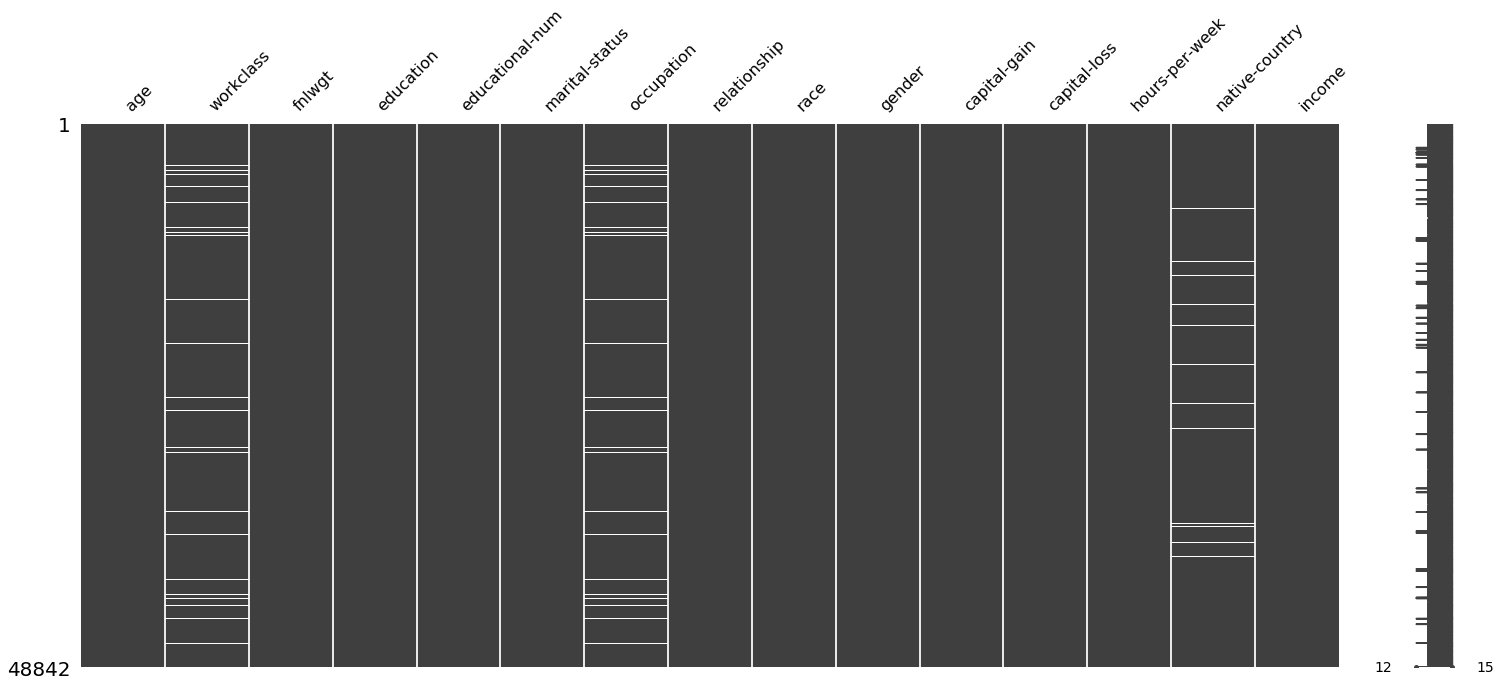

In [5]:
msno.matrix(df);

In [6]:
df.isnull().sum(axis = 0)  # NaN distribution columnwise

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

**Inspección visual del vector objetivo y las demás variables:**

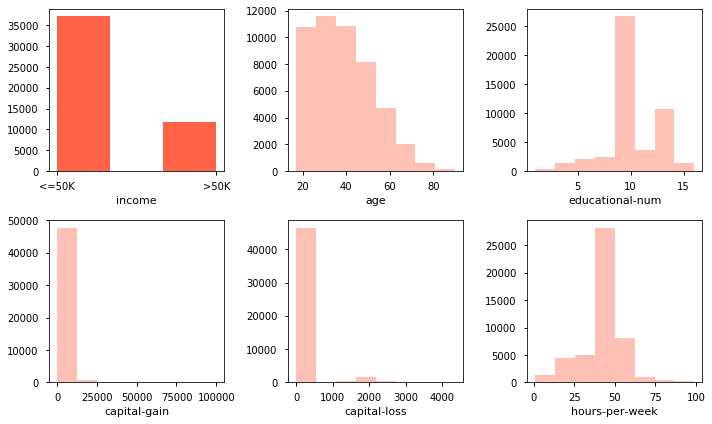

In [7]:
variables_to_plot = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
df['income'].hist(bins=3, color='tomato')
plt.grid(False)
plt.xlabel('income')
for i, var in enumerate(variables_to_plot):
    plt.subplot(2,3,i+2)
    sns.distplot(df[var].dropna(), kde=False, bins=8, color='tomato')
plt.tight_layout()

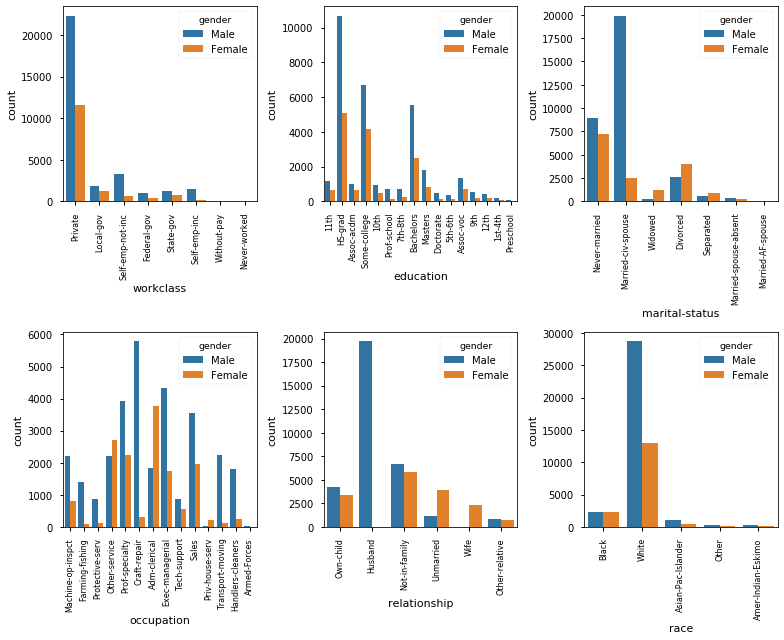

In [8]:
categoricals_to_plot = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race']
plt.figure(figsize=(11,9))
for i, var in enumerate(categoricals_to_plot):
    plt.subplot(2,3,i+1)
    chart = sns.countplot(data=df, x=var, hue='gender')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()

Ninguna de las variables presenta anomalías notables.

La recodificación se puede realizar de la siguiente manera. Primero, defino los grupos, luego aplico la recodificación:

In [9]:
white_collars = ['Prof-specialty', 'Exec-managerial', 'Adm-clerical', 'Sales', 'Tech-support']
blue_collars = ['Craft-repair', 'Machine-op-inspct', 'Transport-moving', 'Handlers-cleaners', 'Farming-fishing', 'Protective-serv', 'Priv-house-serv']
other_collars = ['Other-service', 'Armed-Forces']
federal_gov_wc = ['Federal-gov']
state_level_gov_wc = ['State-goc', 'Local-gov']
self_employed_wc = ['Self-emp-inc', 'Self-emp-not-inc']
unemployed_wc = ['Never-worked', 'Without-pay']
private_wc = ['Private']
preschool_ed = ['Preschool']
elementary_school_ed = ['1st-4th', '5th-6th']
high_school_ed = ['7th-8th', '9th', '10th', '11th', '12th', 'HS-grad']
college_ed = ['Assoc-voc', 'Assoc-acdm', 'Some-college']
university_ed = ['Bachelors', 'Masters', 'Prof-school', 'Doctorate']
married_ms = ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
nmarried_ms = ['Never-married']
divorced_ms = ['Divorced']
separated_ms = ['Separated']
widowed_ms = ['Widowed']
america_reg = ['United-States', 'Mexico', 'Puerto-Rico', 'Canada', 'El-Salvador', 'Cuba', 'Jamaica', 'Dominican-Republic', 'Guatemala', 'Columbia', 'Haiti', 'Nicaragua', 'Peru', 'Ecuador', 'Trinadad&Tobago', 'Outlying-US', 'Honduras']
europe_reg = ['Germany', 'England', 'Italy', 'Poland', 'Portugal', 'Greece', 'France', 'Ireland', 'Yugoslavia', 'Scotland', 'Hungary', 'Holand-Netherlands']
asia_reg = ['Philippines', 'India', 'China', 'Japan', 'Vietnam', 'Taiwan', 'Iran', 'Hong', 'Thailand', 'Cambodia', 'Laos']
africa_reg = ['South']

In [10]:
df['collars'] = df.apply(lambda row: recod_row(row, 'occupation', 'white', white_collars), axis=1)
df['collars'] = df.apply(lambda row: recod_row(row, 'occupation', 'blue', blue_collars) if row['collars'] is np.nan else row['collars'], axis=1)
df['collars'] = df.apply(lambda row: recod_row(row, 'occupation', 'others', other_collars) if row['collars'] is np.nan else row['collars'], axis=1)

In [11]:
df['workclass_recod'] = df.apply(lambda row: recod_row(row, 'workclass', 'federal_gov', federal_gov_wc), axis=1)
df['workclass_recod'] = df.apply(lambda row: recod_row(row, 'workclass', 'state_level_gov', state_level_gov_wc) if row['workclass_recod'] is np.nan else row['workclass_recod'], axis=1)
df['workclass_recod'] = df.apply(lambda row: recod_row(row, 'workclass', 'self_employed', self_employed_wc) if row['workclass_recod'] is np.nan else row['workclass_recod'], axis=1)
df['workclass_recod'] = df.apply(lambda row: recod_row(row, 'workclass', 'unemployed', unemployed_wc) if row['workclass_recod'] is np.nan else row['workclass_recod'], axis=1)
df['workclass_recod'] = df.apply(lambda row: recod_row(row, 'workclass', 'private', private_wc) if row['workclass_recod'] is np.nan else row['workclass_recod'], axis=1)

In [12]:
df['educ_recod'] = df.apply(lambda row: recod_row(row, 'education', 'preschool', preschool_ed), axis=1)
df['educ_recod'] = df.apply(lambda row: recod_row(row, 'education', 'elementary_school', elementary_school_ed) if row['educ_recod'] is np.nan else row['educ_recod'], axis=1)
df['educ_recod'] = df.apply(lambda row: recod_row(row, 'education', 'high_school', high_school_ed) if row['educ_recod'] is np.nan else row['educ_recod'], axis=1)
df['educ_recod'] = df.apply(lambda row: recod_row(row, 'education', 'college', college_ed) if row['educ_recod'] is np.nan else row['educ_recod'], axis=1)
df['educ_recod'] = df.apply(lambda row: recod_row(row, 'education', 'university', university_ed) if row['educ_recod'] is np.nan else row['educ_recod'], axis=1)

In [13]:
df['civstatus'] = df.apply(lambda row: recod_row(row, 'marital-status', 'married', married_ms), axis=1)
df['civstatus'] = df.apply(lambda row: recod_row(row, 'marital-status', 'nmarried', nmarried_ms) if row['civstatus'] is np.nan else row['civstatus'], axis=1)
df['civstatus'] = df.apply(lambda row: recod_row(row, 'marital-status', 'divorced', divorced_ms) if row['civstatus'] is np.nan else row['civstatus'], axis=1)
df['civstatus'] = df.apply(lambda row: recod_row(row, 'marital-status', 'separated', separated_ms) if row['civstatus'] is np.nan else row['civstatus'], axis=1)
df['civstatus'] = df.apply(lambda row: recod_row(row, 'marital-status', 'widowed', widowed_ms) if row['civstatus'] is np.nan else row['civstatus'], axis=1)

In [14]:
df['region'] = df.apply(lambda row: recod_row(row, 'native-country', 'america', america_reg), axis=1)
df['region'] = df.apply(lambda row: recod_row(row, 'native-country', 'europe', europe_reg) if row['region'] is np.nan else row['region'], axis=1)
df['region'] = df.apply(lambda row: recod_row(row, 'native-country', 'asia', asia_reg) if row['region'] is np.nan else row['region'], axis=1)
df['region'] = df.apply(lambda row: recod_row(row, 'native-country', 'africa', africa_reg) if row['region'] is np.nan else row['region'], axis=1)

In [15]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [16]:
df['>50k'] = np.where(df['income']=='>50K', 1, 0)

Para reducir colinearidad, elimino las columnas que contienen la misma información. Además elimino `fnlwgt`, porque es una variable que sabemos no aporta en nada al modelamiento:

In [17]:
df = df.drop(columns=['occupation', 'workclass', 'education', 'marital-status', 'native-country', 'income', 'fnlwgt'])

También reviso la matriz de correlaciones:

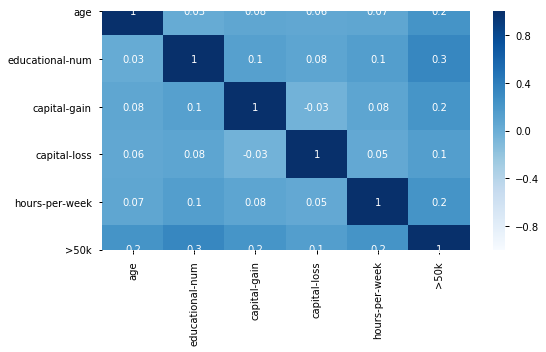

In [18]:
dfcorr = df.corr().dropna()
plt.rcParams['figure.figsize'] = 8, 5
ax = sns.heatmap(dfcorr, annot=True, cmap='Blues', vmin=-1, vmax=1, fmt='.1g')
plt.tight_layout()

En donde podemos confirmar que no existe una colinealidad evidente entre mis regresores.

### Generación de modelos

A continuación generaré `mod1`, un modelo saturado que incluya todos los regresores.

In [19]:
X = df.drop(['>50k'], axis=1)  # features
y = df['>50k']  # target

In [20]:
print(f'Sample size = {y.shape[0]}')
print(f'Features    = {X.shape[1]}')

Sample size = 48842
Features    = 13


De las :

4 regresores NUMÉRICOS →\
`age`, `capital-gain`, `capital-loss`, `hours-per-week`

9 regresores CATEGÓRICOS →\
`relationship` (6), `educational-num` (16), `race` (5), `gender` (2), `collars` (3),\
`workclass_recod` (5), `education_recod` (5), `civstatus` (4), `region` (4)

Ahora construiré la pipeline para todo el proceso:\
(1) proprocesamiento de los datos, que incluye manejo de valores inválidos por `SimpleImputer()`,\
codificación de clases para las variables categóricas via `OneHotEncoder()`,\
y estandarización para las variables numéricas usando `StandardScaler()`, y\
(2) modelamiento.

Nota: Como estrategia para manejar datos NaN, usaré imputación estadística de datos (utilizando la mediana) antes que la eliminación del registro. Esto es porque debido a la poca cantidad de valores NaN, prefiero reemplazar sus valores por uno representativo de la distribución antes que eliminar el registro por completo. El posible efecto de introducción de sesgo en la muestra debido a datos imputados se considera despreciable.

In [21]:
numeric_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [22]:
categorical_features = ['relationship', 'educational-num', 'race', 'gender', 'collars', 'workclass_recod', 'civstatus', 'region']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [24]:
logreg_pip = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', LogisticRegression(solver='lbfgs', max_iter=1000))])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
mod1 = logreg_pip.fit(X_train, y_train)

In [27]:
y_test_pred_log = mod1.predict(X_test)  # make prediction, logreg
y_test_pred_probs_log = mod1.predict_proba(X_test)[:,1]  # get probabilities of predicted classes, logreg

En este punto ya es posible hacer predicciones con el modelo `mod1`.

A continuación generaré `mod2`, un modelo depurado que incluya sólo los regresores de más alta significancia estadística. Para ello usaré una binarización explícita de las variables, y seleccionaré de acuerdo a ello.

In [28]:
import re
df2 = df.rename(columns={'>50k': 'more_than_50k'})
df2 = df2.dropna()

In [29]:
cols = binarize(df2)
df2 = df2.drop(columns=cols)
df2 = df2.rename(columns=lambda x: re.sub('-','_',x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
age                48842 non-null int64
educational-num    48842 non-null int64
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
collars            46033 non-null object
workclass_recod    44062 non-null object
educ_recod         48842 non-null object
civstatus          48842 non-null object
region             47962 non-null object
>50k               48842 non-null int64
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


En este punto usaré `statmodels` para generar una regresión logística que me entregue un desglose estadístico de los _p-value_, que dado un valor crítico podré seleccionar iterativamente para generar cada nuevo modelo depurado:

In [30]:
mod_logit = smf.logit(generate_formula(df2.columns.tolist(), 'more_than_50k'), data=df2).fit()

Optimization terminated successfully.
         Current function value: 0.331528
         Iterations 11


In [31]:
table = mod_logit.summary2().tables[1]['P>|z|']
low_sig = [table.index[i] for i, value in enumerate(table) if value >= 5/100 and i != 0]
low_sig

['bin_race_Other',
 'bin_workclass_recod_state_level_gov',
 'bin_workclass_recod_unemployed',
 'bin_educ_recod_college',
 'bin_educ_recod_elementary_school',
 'bin_educ_recod_preschool',
 'bin_region_europe']

In [32]:
df2 = df2.drop(columns=low_sig)

En este punto, `df2` corresponde a un dataframe depurado una vez (_1-depurado_). Luego generaré un dataframe _2-depurado_ y para cada uno crearé un modelo, cuyos rendimientos podré comparar más tarde. Ahora puedo generar `mod2`, usando `df2`.

In [33]:
X2 = df2.drop(['more_than_50k'], axis=1)  # features
y2 = df2['more_than_50k']  # target
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

In [34]:
mod2 = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X2_train, y2_train)
y2_test_pred_log = mod2.predict(X2_test)  # make prediction, logreg
y2_test_pred_probs_log = mod2.predict_proba(X2_test)[:,1]  # get probabilities of predicted classes, logreg

En este punto ya es posible hacer predicciones con el modelo `mod2`.

A continuación generaré `mod3`, un modelo _2-depurado_ que incluya sólo los regresores de más alta significancia estadística.

In [35]:
mod_logit2 = smf.logit(generate_formula(df2.columns.tolist(), 'more_than_50k'), data=df2).fit()

Optimization terminated successfully.
         Current function value: 0.331702
         Iterations 9


In [36]:
table2 = mod_logit2.summary2().tables[1]['P>|z|']
low_sig2 = [ table2.index[i] for i, value in enumerate(table2) if value >= 5/100 and i != 0 ]
low_sig2

['bin_educ_recod_university']

In [37]:
df3 = df2.drop(columns=low_sig2)

En este punto, `df3` corresponde a un dataframe depurado dos veces (_2-depurado_). Ahora puedo generar `mod3`, usando `df3`.

In [38]:
X3 = df3.drop(['more_than_50k'], axis=1)  # features
y3 = df3['more_than_50k']  # target
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33, random_state=42)

In [39]:
mod3 = LogisticRegression(solver='lbfgs', max_iter=5000).fit(X3_train, y3_train)
y3_test_pred_log = mod3.predict(X3_test)  # make prediction, logreg
y3_test_pred_probs_log = mod3.predict_proba(X3_test)[:,1]  # get probabilities of predicted classes, logreg

En este punto ya es posible hacer predicciones con el modelo `mod3.`

### Evaluación de modelos

Model 1: Logistic Regression (saturado)
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12316
           1       0.74      0.60      0.66      3802

    accuracy                           0.85     16118
   macro avg       0.81      0.77      0.78     16118
weighted avg       0.85      0.85      0.85     16118



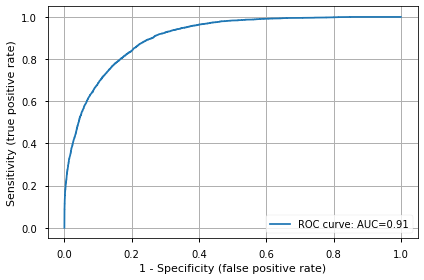

In [40]:
get_model_evaluation_report(y_test, y_test_pred_log, y_test_pred_probs_log, 'Model 1: Logistic Regression (saturado)')

Model 2: Logistic Regression (1-depurado)
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10750
           1       0.72      0.61      0.66      3525

    accuracy                           0.85     14275
   macro avg       0.80      0.76      0.78     14275
weighted avg       0.84      0.85      0.84     14275



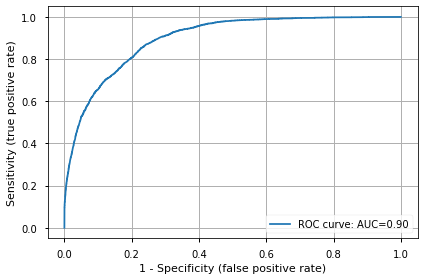

In [41]:
get_model_evaluation_report(y2_test, y2_test_pred_log, y2_test_pred_probs_log, 'Model 2: Logistic Regression (1-depurado)')

Model 3: Logistic Regression (2-depurado)
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10750
           1       0.72      0.61      0.66      3525

    accuracy                           0.84     14275
   macro avg       0.80      0.76      0.78     14275
weighted avg       0.84      0.84      0.84     14275



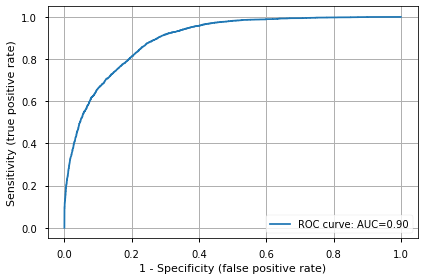

In [42]:
get_model_evaluation_report(y3_test, y3_test_pred_log, y3_test_pred_probs_log, 'Model 3: Logistic Regression (2-depurado)')

In [43]:
cm1 = get_confusion_matrix(y_test, y_test_pred_log)
cm2 = get_confusion_matrix(y2_test, y2_test_pred_log)
cm3 = get_confusion_matrix(y3_test, y3_test_pred_log)
display_side_by_side(cm1, cm2, cm3)

,actual positive,actual negative
predicted positive,TP = 2270,FP = 809 (type I)
predicted negative,FN = 1532 (type II),TN = 11507
,actual positive,actual negative
predicted positive,TP = 2135,FP = 818 (type I)
predicted negative,FN = 1390 (type II),TN = 9932
,actual positive,actual negative
predicted positive,TP = 2134,FP = 827 (type I)
predicted negative,FN = 1391 (type II),TN = 9923


In [44]:
scores1 = pd.DataFrame.from_dict(get_scores(confusion_matrix(y_test, y_test_pred_log)), columns=['sat'], orient='index')
scores2 = pd.DataFrame.from_dict(get_scores(confusion_matrix(y2_test, y2_test_pred_log)), columns=['1-dep'], orient='index')
scores3 = pd.DataFrame.from_dict(get_scores(confusion_matrix(y3_test, y3_test_pred_log)), columns=['2-dep'], orient='index')
round(pd.concat([scores1, scores2, scores3], axis=1, join='inner'), ndigits=3)

,sat,1-dep,2-dep
precision,0.737,0.723,0.721
accuracy,0.855,0.845,0.845
sensitivity (recall),0.597,0.606,0.605
specificity,0.934,0.924,0.923
neg_pred_value,0.883,0.877,0.877
f1,0.660,0.659,0.658


Vemos que desde el punto de vista de las métricas de evaluación del modelamiento, todos los modelos tienen un rendimiento bastante bueno y similar. Para decidir cuál es el mejor modelo predictivo, estudiaré la sensibilidad de predicción usando dos registros de los que razonablemente sé cuánto debería predecir y con qué probabilidad.

### Pruebas de predicción

Para cada modelo, probaré con 2 casos extremos:

(1) un hombre blanco europeo con ganacias fuera del salario, trabajo administrativo en una compañía privada; vs\
(2) una mujer negra africana sin ganancias extra, casada y desempleada.

In [45]:
df.columns.tolist()

['age',
 'educational-num',
 'relationship',
 'race',
 'gender',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'collars',
 'workclass_recod',
 'educ_recod',
 'civstatus',
 'region',
 '>50k']

In [46]:
rich = np.array([40.0, 16, 'Unmarried', 'White', 'Male' , 10000, 0, 40, 'white', 'private', 'university'   , 'nmarried', 'europe']).reshape(1,-1)
poor = np.array([20.0,  9, 'Wife'     , 'Black', 'Woman',   100, 0,  0, 'blue' , 'unemployed', 'preschool' , 'married', 'africa']).reshape(1,-1)

In [47]:
rich = pd.DataFrame(data=rich, columns=df.columns[:-1])
poor = pd.DataFrame(data=poor, columns=df.columns[:-1])

In [48]:
df2.columns.tolist()

['age',
 'educational_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'more_than_50k',
 'bin_relationship_Not_in_family',
 'bin_relationship_Own_child',
 'bin_relationship_Unmarried',
 'bin_relationship_Wife',
 'bin_relationship_Other_relative',
 'bin_race_Black',
 'bin_race_Asian_Pac_Islander',
 'bin_race_Amer_Indian_Eskimo',
 'bin_gender_Female',
 'bin_collars_blue',
 'bin_collars_others',
 'bin_workclass_recod_self_employed',
 'bin_workclass_recod_federal_gov',
 'bin_educ_recod_university',
 'bin_civstatus_nmarried',
 'bin_civstatus_divorced',
 'bin_civstatus_separated',
 'bin_civstatus_widowed',
 'bin_region_asia',
 'bin_region_africa']

In [49]:
rich2 = np.array([40, 16, 10000, 0, 40,
                  0, 0, 1, 0, 0,  # bin_relationship → Unmarried
                  0, 0, 0,        # bin_race → White
                  0,              # bin_gender → Male
                  0, 0,           # bin_collars → white
                  0, 0,           # bin_workclass → private
                  1,              # bin_educ_recod → university
                  1, 0, 0, 0,     # bin_civstatus → nmarried
                  0, 0            # bin_region → europe
                  ]).reshape(1,-1)

In [50]:
poor2 = np.array([20, 9, 100, 0, 0,
                  0, 0, 0, 1, 0,  # bin_relationship → Wife
                  1, 0, 0,        # bin_race → Black
                  1,              # bin_gender → Female
                  1, 0,           # bin_collars → blue
                  0, 0,           # bin_workclass → unemployed
                  0,              # bin_educ_recod → preschool
                  0, 0, 0, 0,     # bin_civstatus → married
                  0, 1            # bin_region → africa
                  ]).reshape(1,-1)

In [51]:
rich2 = pd.DataFrame(data=rich2, columns=df2.columns.tolist().remove('more_than_50k'))
poor2 = pd.DataFrame(data=poor2, columns=df2.columns.tolist().remove('more_than_50k'))

In [52]:
df3.columns.tolist()

['age',
 'educational_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'more_than_50k',
 'bin_relationship_Not_in_family',
 'bin_relationship_Own_child',
 'bin_relationship_Unmarried',
 'bin_relationship_Wife',
 'bin_relationship_Other_relative',
 'bin_race_Black',
 'bin_race_Asian_Pac_Islander',
 'bin_race_Amer_Indian_Eskimo',
 'bin_gender_Female',
 'bin_collars_blue',
 'bin_collars_others',
 'bin_workclass_recod_self_employed',
 'bin_workclass_recod_federal_gov',
 'bin_civstatus_nmarried',
 'bin_civstatus_divorced',
 'bin_civstatus_separated',
 'bin_civstatus_widowed',
 'bin_region_asia',
 'bin_region_africa']

In [53]:
rich3 = np.array([40, 16, 10000, 0, 40,
                  0, 0, 1, 0, 0,  # bin_relationship → Unmarried
                  0, 0, 0,        # bin_race → White
                  0,              # bin_gender → Male
                  0, 0,           # bin_collars → white
                  0, 0,           # bin_workclass → private
                  1, 0, 0, 0,     # bin_civstatus → nmarried
                  0, 0            # bin_region → europe
                  ]).reshape(1,-1)

In [54]:
poor3 = np.array([20, 9, 100, 0, 0,
                  0, 0, 0, 1, 0,  # bin_relationship → Wife
                  1, 0, 0,        # bin_race → Black
                  1,              # bin_gender → Female
                  1, 0,           # bin_collars → blue
                  0, 0,           # bin_workclass → unemployed
                  0, 0, 0, 0,     # bin_civstatus → married
                  0, 1            # bin_region → africa
                  ]).reshape(1,-1)

In [55]:
rich3 = pd.DataFrame(data=rich3, columns=df3.columns.tolist().remove('more_than_50k'))
poor3 = pd.DataFrame(data=poor3, columns=df3.columns.tolist().remove('more_than_50k'))

**En resumen:**

In [56]:
print(f"Modelo 1, caso 1: con una probabilidad de {mod1.predict_proba(rich)[0][1]:.2f},\
la predicción de un salario >50k anual es {mod1.predict(rich)[0]}")
print(f"Modelo 1, caso 2: con una probabilidad de {mod1.predict_proba(poor)[0][1]:.2f},\
la predicción de un salario >50k anual es {mod1.predict(poor)[0]}")
print(f"Modelo 2, caso 1: con una probabilidad de {mod2.predict_proba(rich2)[0][1]:.2f},\
la predicción de un salario >50k anual es {mod2.predict(rich2)[0]}")
print(f"Modelo 2, caso 2: con una probabilidad de {mod2.predict_proba(poor2)[0][1]:.2f},\
la predicción de un salario >50k anual es {mod2.predict(poor2)[0]}")
print(f"Modelo 3, caso 1: con una probabilidad de {mod3.predict_proba(rich3)[0][1]:.2f},\
la predicción de un salario >50k anual es {mod3.predict(rich3)[0]}")
print(f"Modelo 3, caso 2: con una probabilidad de {mod3.predict_proba(poor3)[0][1]:.2f},\
la predicción de un salario >50k anual es {mod3.predict(poor3)[0]}")

Modelo 1, caso 1: con una probabilidad de 0.51,la predicción de un salario >50k anual es 1
Modelo 1, caso 2: con una probabilidad de 0.02,la predicción de un salario >50k anual es 0
Modelo 2, caso 1: con una probabilidad de 0.86,la predicción de un salario >50k anual es 1
Modelo 2, caso 2: con una probabilidad de 0.06,la predicción de un salario >50k anual es 0
Modelo 3, caso 1: con una probabilidad de 0.89,la predicción de un salario >50k anual es 1
Modelo 3, caso 2: con una probabilidad de 0.06,la predicción de un salario >50k anual es 0


De esta manera, concluyo que mi modelo con mejor capacidad predictiva y mejor sensibilidad es el Modelo 3, ya que reacciona adecuadamente ante cambios en _features_ relevantes.